In [1]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lines = []
with open("result.txt", "r") as fp:
    for line in fp:
        lines.append(list(map(float, line.strip().split())))

In [3]:
dat = np.array(lines, dtype=np.float64)
y = np.linspace(-0.2, 4.2, dat.shape[0])
x = np.linspace(-3.2, 3.2, dat.shape[1]),
X, Y = np.meshgrid(x, y)
Z = dat

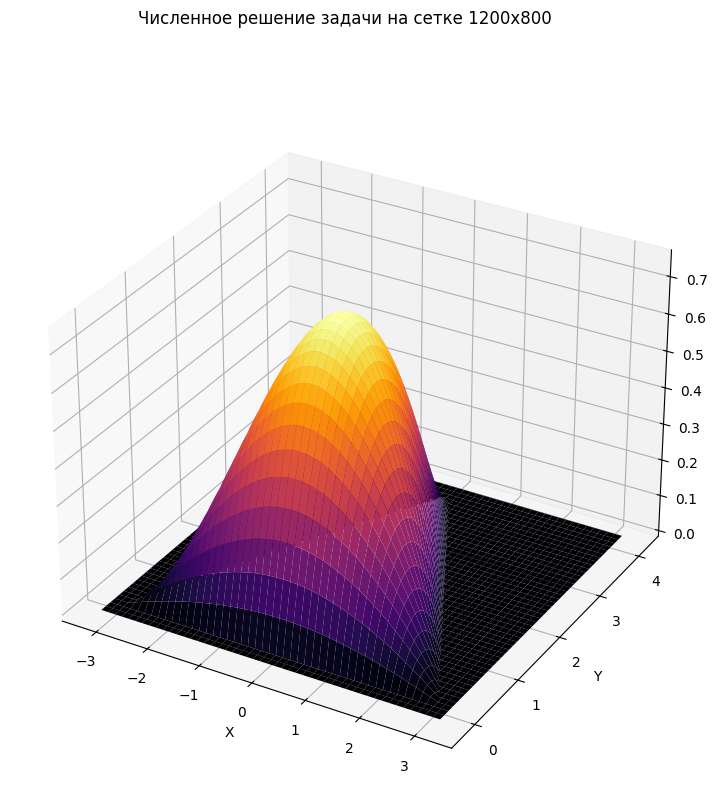

In [4]:
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
fig.suptitle("Численное решение задачи на сетке 1200x800")
ax.plot_surface(X, Y, Z, cmap="inferno")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(30)
fig.savefig("solution_plot.png")
plt.show()

In [5]:
ystep = 4.4 / dat.shape[0]
xstep = 6.4 / dat.shape[1]

residual = (
    -(dat[2:, 1:-1] - 2 * dat[1:-1, 1:-1] + dat[:-2, 1:-1]) / (ystep**2)
    -(dat[1:-1, 2:] - 2 * dat[1:-1, 1:-1] + dat[1:-1, :-2]) / (xstep**2)
    -1.
)

Text(0, 0.5, 'y')

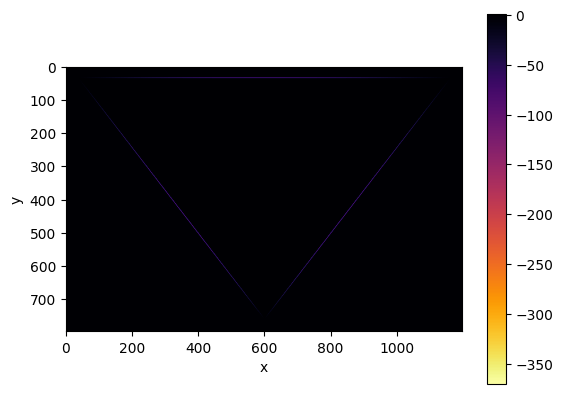

In [6]:
plt.imshow(residual, cmap="inferno_r")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")

In [ ]:
import os
import pandas as pd


def parse_elapsed_time(path):
    elapsed_time = None
    with open(path, "r") as fp:
        for line in fp:
            if "Elapsed time:" in line:
                elapsed_time = float(line.split("Elapsed time: ")[1].split(" seconds")[0])
    return elapsed_time


def parse_iter_num(path):
    iter_num = 0
    with open(path, "r") as fp:
        for line in fp:
            if line.startswith("Step "):
                iter_num = int(line.split("Step ")[1].split(":")[0]) + 1
    return iter_num


if __name__ == "__main__":
    results = []

    cpu_prefix = "bsub_results/cpu"
    for path in os.listdir(cpu_prefix):
        full_path = os.path.join(cpu_prefix, path)
        grid_size = path.split("_")[1].split(".txt")[0]
        if path.startswith("fout"):
            elapsed_time = parse_elapsed_time(full_path)
            iter_num = parse_iter_num(full_path)
            results.append(
                {
                    "kind": "cpu",
                    "grid_size": grid_size,
                    "iter_num": iter_num,
                    "elapsed_time": elapsed_time,
                    "num_threads": 1,
                    "xdim": int(grid_size.split("x")[0]),
                    "speedup": 1.,
                }
            )
    cpu_df = pd.DataFrame(results)

    omp_prefix = "bsub_results/omp"
    for path in os.listdir(omp_prefix):
        full_path = os.path.join(omp_prefix, path)
        grid_size = path.split("_")[1]
        num_threads = path.split("_")[2].split(".txt")[0]
        if path.startswith("fout"):
            elapsed_time = parse_elapsed_time(full_path)
            iter_num = parse_iter_num(full_path)
            results.append(
                {
                    "kind": f"omp_{num_threads}",
                    "grid_size": grid_size,
                    "iter_num": iter_num,
                    "elapsed_time": elapsed_time,
                    "num_threads": int(num_threads),
                    "xdim": int(grid_size.split("x")[0]),
                    "speedup": float(cpu_df.loc[cpu_df.grid_size==grid_size, "elapsed_time"].to_numpy()[0]) / elapsed_time,
                }
            )

    res = (
        pd.DataFrame(results)
        .sort_values(by=["xdim", "num_threads"])
    )

In [8]:
res

,kind,grid_size,iter_num,elapsed_time,num_threads,xdim,speedup
1,cpu,600x400,477,3.670,1,600,1.000000
9,omp_2,600x400,477,2.948,2,600,1.244912
3,omp_4,600x400,477,2.367,4,600,1.550486
11,omp_8,600x400,477,1.826,8,600,2.009858
8,omp_16,600x400,477,1.389,16,600,2.642189
6,omp_32,600x400,477,0.705,32,600,5.205674
0,cpu,1200x800,718,22.860,1,1200,1.000000
2,omp_2,1200x800,718,18.793,2,1200,1.216410
7,omp_4,1200x800,718,14.634,4,1200,1.562116
5,omp_8,1200x800,718,8.843,8,1200,2.585096


In [9]:
res_omp = res[res["kind"] != "cpu"].rename(
    columns={
        "num_threads": "Количество нитей OpenMP",
        "speedup": "Ускорение, количество раз",
        "grid_size": "Размер сетки",
    }
)
res_omp

,kind,Размер сетки,iter_num,elapsed_time,Количество нитей OpenMP,xdim,"Ускорение, количество раз"
9,omp_2,600x400,477,2.948,2,600,1.244912
3,omp_4,600x400,477,2.367,4,600,1.550486
11,omp_8,600x400,477,1.826,8,600,2.009858
8,omp_16,600x400,477,1.389,16,600,2.642189
6,omp_32,600x400,477,0.705,32,600,5.205674
2,omp_2,1200x800,718,18.793,2,1200,1.216410
7,omp_4,1200x800,718,14.634,4,1200,1.562116
5,omp_8,1200x800,718,8.843,8,1200,2.585096
4,omp_16,1200x800,718,8.274,16,1200,2.762872
10,omp_32,1200x800,718,6.017,32,1200,3.799235


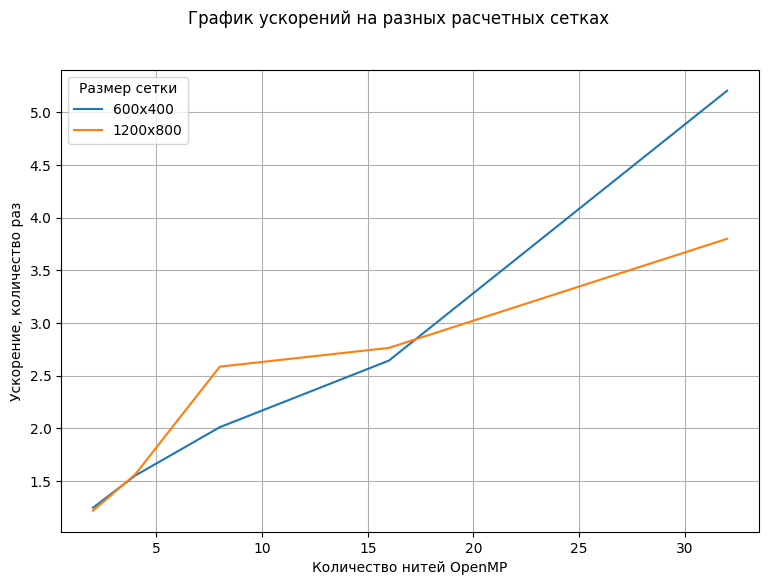

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(9, 6))
fig.suptitle("График ускорений на разных расчетных сетках")

sns.lineplot(
    res_omp,
    x="Количество нитей OpenMP",
    y="Ускорение, количество раз",
    hue="Размер сетки"
)

ax.grid(True)
fig.savefig("speedup.png")
plt.show()